### Importing Libraries ###

In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Data Preparation ###

In [2]:
# Paths for data.
Ravdess = "D:\\Projects\\Speech Emotion Recognition\\RAVDESS Emotional speech audio\\audio_speech_actors_01-24\\"
Crema = "D:\\Projects\\Speech Emotion Recognition\\CREMA-D\\AudioWAV\\"
Tess = "D:\\Projects\\Speech Emotion Recognition\\Toronto emotional speech set (TESS)\\TESS Toronto emotional speech set data\\"
Savee = "D:\\Projects\\Speech Emotion Recognition\\Surrey Audio-Visual Expressed Emotion (SAVEE)\\ALL\\"

### Ravdess Dataframe ###

In [4]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0  neutral  D:\Projects\Speech Emotion Recognition\RAVDESS...
1  neutral  D:\Projects\Speech Emotion Recognition\RAVDESS...
2  neutral  D:\Projects\Speech Emotion Recognition\RAVDESS...
3  neutral  D:\Projects\Speech Emotion Recognition\RAVDESS...
4     calm  D:\Projects\Speech Emotion Recognition\RAVDESS...

### Crema DataFrame ###

In [5]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0    angry  D:\Projects\Speech Emotion Recognition\CREMA-D...
1  disgust  D:\Projects\Speech Emotion Recognition\CREMA-D...
2     fear  D:\Projects\Speech Emotion Recognition\CREMA-D...
3    happy  D:\Projects\Speech Emotion Recognition\CREMA-D...
4  neutral  D:\Projects\Speech Emotion Recognition\CREMA-D...

### TESS dataset ###

In [7]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0    angry  D:\Projects\Speech Emotion Recognition\Toronto...
1    angry  D:\Projects\Speech Emotion Recognition\Toronto...
2    angry  D:\Projects\Speech Emotion Recognition\Toronto...
3    angry  D:\Projects\Speech Emotion Recognition\Toronto...
4    angry  D:\Projects\Speech Emotion Recognition\Toronto...

### CREMA-D dataset ###

In [8]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                               Path
0    angry  D:\Projects\Speech Emotion Recognition\Surrey ...
1    angry  D:\Projects\Speech Emotion Recognition\Surrey ...
2    angry  D:\Projects\Speech Emotion Recognition\Surrey ...
3    angry  D:\Projects\Speech Emotion Recognition\Surrey ...
4    angry  D:\Projects\Speech Emotion Recognition\Surrey ...

In [9]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0  neutral  D:\Projects\Speech Emotion Recognition\RAVDESS...
1  neutral  D:\Projects\Speech Emotion Recognition\RAVDESS...
2  neutral  D:\Projects\Speech Emotion Recognition\RAVDESS...
3  neutral  D:\Projects\Speech Emotion Recognition\RAVDESS...
4     calm  D:\Projects\Speech Emotion Recognition\RAVDESS...

### Data Visualisation and Exploration ###

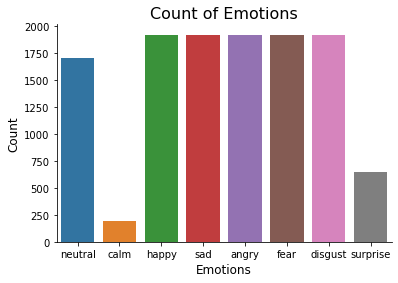

In [10]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [11]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

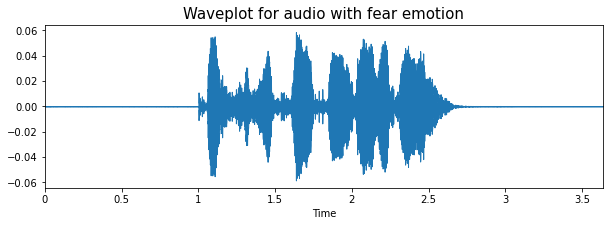

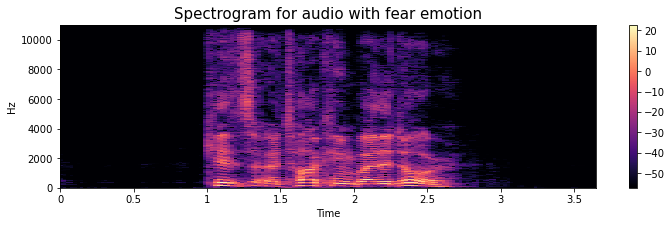

In [12]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

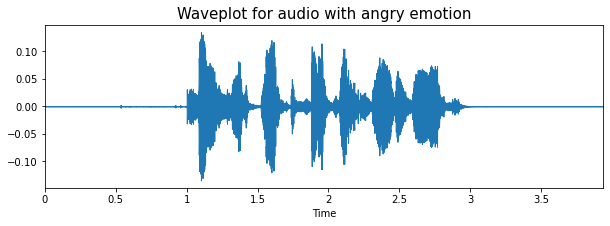

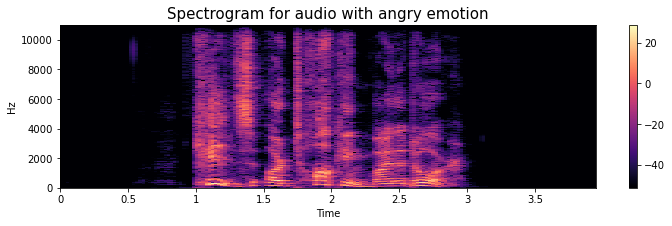

In [13]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

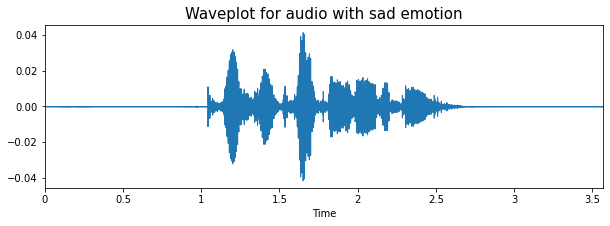

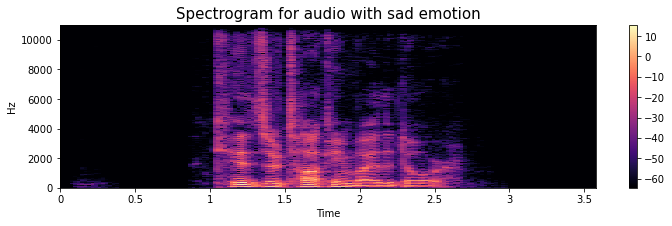

In [14]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

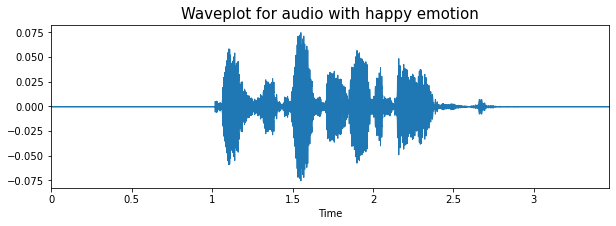

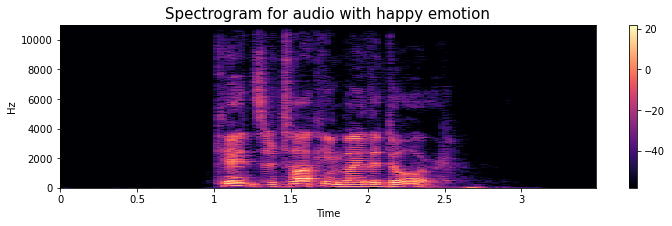

In [15]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

### Data Augmentation ###

In [16]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### Simple Audio ####

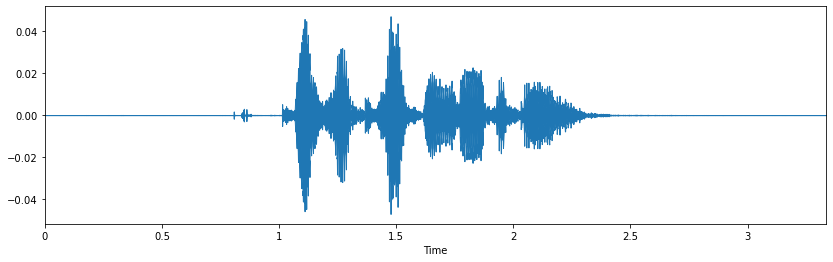

In [17]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

#### Noise Injection ####

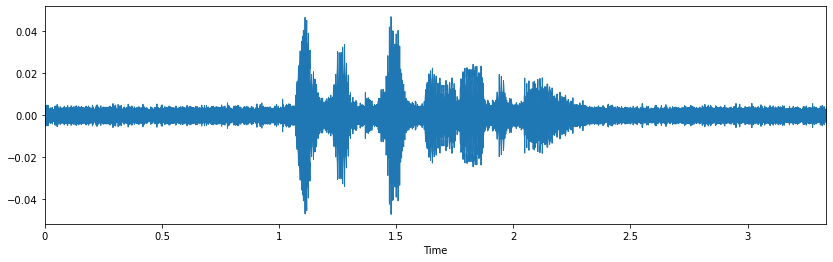

In [18]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### Stretching ####

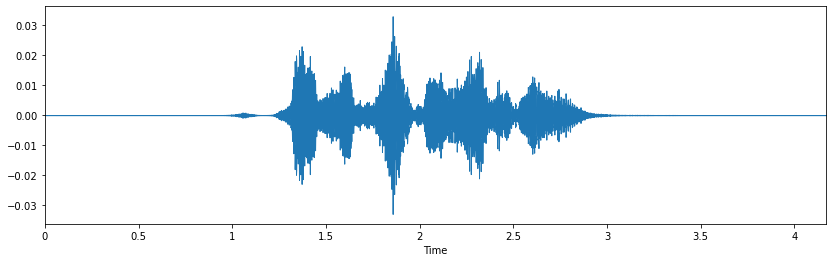

In [19]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### Shifting ####

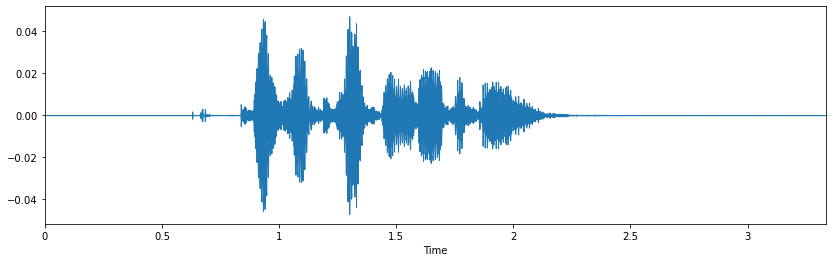

In [20]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### Pitch ####

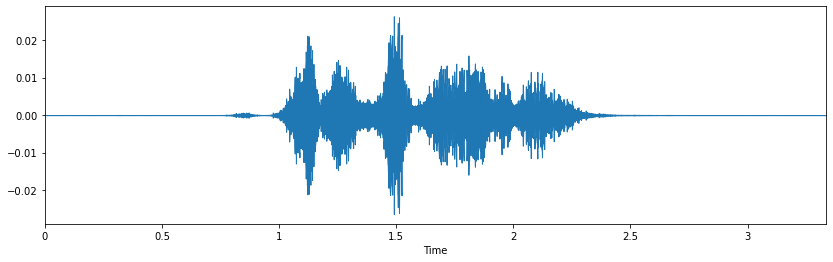

In [21]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### Feature Extraction ###

In [22]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [23]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [24]:
len(X), len(Y), data_path.Path.shape

(36486, 36486, (12162,))

In [25]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.300781  0.706492  0.756853  0.735217  0.731014  0.715155  0.667529   
1  0.324725  0.823594  0.835910  0.814704  0.821305  0.811268  0.697069   
2  0.176693  0.640605  0.712837  0.743736  0.714797  0.701402  0.694569   
3  0.271272  0.674966  0.723259  0.724594  0.681302  0.670643  0.674574   
4  0.303051  0.761390  0.803593  0.786066  0.764111  0.775563  0.727023   

          7         8         9  ...           153       154       155  \
0  0.673754  0.722173  0.748969  ...  4.319263e-06  0.000003  0.000002   
1  0.697026  0.738925  0.774811  ...  9.586391e-05  0.000094  0.000090   
2  0.663853  0.688527  0.742508  ...  7.999367e-07  0.000001  0.000001   
3  0.630036  0.680146  0.708276  ...  6.998011e-06  0.000007  0.000007   
4  0.642163  0.688485  0.728906  ...  4.187000e-05  0.000044  0.000046   

            156           157           158       159           160  \
0  2.286677e-06  5.131693e-06  8.065748e-06  0.000005  2.270858e-06   
1  8.810951e-05  8.954591e-05  9.645584e-05  0.000096  9.002181e-05   
2  5.350822e-07  3.480663e-07  8.398365e-07  0.000001  4.287777e-07   
3  6.999257e-06  1.217880e-05  9.449916e-06  0.000008  2.638513e-06   
4  4.308147e-05  4.708242e-05  4.556777e-05  0.000047  3.630199e-05   

            161   labels  
0  1.642365e-07  neutral  
1  9.257274e-05  neutral  
2  2.878995e-08  neutral  
3  1.788902e-07  neutral  
4  3.542639e-05  neutral  

[5 rows x 163 columns]

### Data Preparation ###

In [26]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [27]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [28]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [29]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [30]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

### Modelling ###

In [31]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 162, 256)          1536      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 81, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 81, 256)           327936    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 41, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 41, 128)           163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 21, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 128)           0

In [32]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
428/428 [==============================] - 29s 67ms/step - loss: 1.7473 - accuracy: 0.2921 - val_loss: 1.5270 - val_accuracy: 0.3857
Epoch 2/50
428/428 [==============================] - 28s 65ms/step - loss: 1.5197 - accuracy: 0.3834 - val_loss: 1.4374 - val_accuracy: 0.4144
Epoch 3/50
428/428 [==============================] - 27s 64ms/step - loss: 1.4411 - accuracy: 0.4155 - val_loss: 1.3389 - val_accuracy: 0.4660
Epoch 4/50
428/428 [==============================] - 27s 64ms/step - loss: 1.3896 - accuracy: 0.4397 - val_loss: 1.2893 - val_accuracy: 0.4818
Epoch 5/50
428/428 [==============================] - 27s 64ms/step - loss: 1.3497 - accuracy: 0.4603 - val_loss: 1.2480 - val_accuracy: 0.5024
Epoch 6/50
428/428 [==============================] - 27s 64ms/step - loss: 1.3066 - accuracy: 0.4753 - val_loss: 1.2356 - val_accuracy: 0.5052
Epoch 7/50
428/428 [==============================] - 27s 64ms/step - loss: 1.2656 - accuracy: 0.4953 - val_loss: 1.2150 - val_accuracy:

286/286 [==============================] - 3s 11ms/step - loss: 1.1176 - accuracy: 0.6123
Accuracy of our model on test data :  61.225610971450806 %


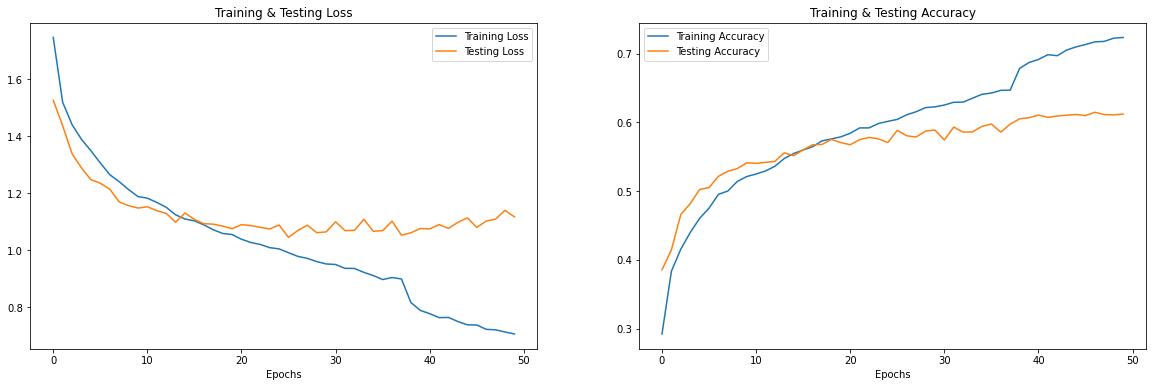

In [33]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [34]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [35]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0              sad       disgust
1          disgust       disgust
2            angry         angry
3          disgust       disgust
4             fear          fear
5              sad          fear
6            happy         happy
7            happy         happy
8          disgust           sad
9          neutral           sad

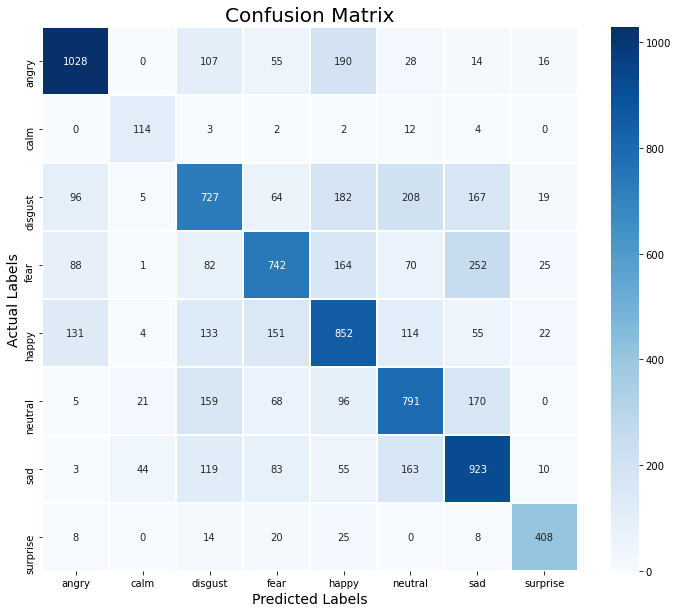

In [36]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.76      0.71      0.74      1438
        calm       0.60      0.83      0.70       137
     disgust       0.54      0.50      0.52      1468
        fear       0.63      0.52      0.57      1424
       happy       0.54      0.58      0.56      1462
     neutral       0.57      0.60      0.59      1310
         sad       0.58      0.66      0.62      1400
    surprise       0.82      0.84      0.83       483

    accuracy                           0.61      9122
   macro avg       0.63      0.66      0.64      9122
weighted avg       0.61      0.61      0.61      9122

